<a href="https://colab.research.google.com/github/cdavidrios/AulaSemillaTDS1/blob/main/Muestreo_ADC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*librerias a instalar*

In [1]:
!pip install pydub

*Librerias*


In [2]:
import numpy as np
from pydub import AudioSegment
from scipy.signal import butter, lfilter, resample
from IPython.display import Audio, display, HTML
import matplotlib.pyplot as plt
import librosa as lib
from scipy import interpolate
import librosa.display

*Funciones*


In [3]:

# Function to create a low-pass Butterworth filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Function to apply the filter to data
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    return y

def plot_spectrogram(data, fs):
  '''
  Parameter:
  data: señal a la que se le calcula el espectrograma
  fs: frecuencia de muestreo de la señal
  '''
  # Resolución del espectrograma
  num =  1024
  hop = num//8

  stft = np.abs(librosa.stft(data,  n_fft=num, hop_length=hop  ))
  D = librosa.amplitude_to_db(stft, ref = np.max)
  spec = librosa.display.specshow(D, sr=fs, x_axis='time', y_axis='linear', cmap=None, hop_length=hop)

def sample_and_hold(t_org, signal, fs_ori, fs_dest):
  t_dest = 1/fs_dest
  i = 0
  signal_resample = np.zeros(len(signal))
  samples = []
  t_sample= []
  while i* t_dest < max(t_org):
    idx_sample = np.where((t_org >= i *t_dest) & (t_org < i + 1 * t_dest))[0]
    signal_resample[idx_sample[0]: idx_sample[-1] +1 ] = signal[idx_sample[0]]
    samples.append(signal[idx_sample[0]])
    t_sample.append(i *t_dest)
    i += 1
  return signal_resample, t_sample, samples



def fxquant (s , bit ) :
  # s : senal de entrada , debe estar normalizada entre -1 y 1
  # bit : bits de cuantizacion
  Plus1 = np.power(2,(bit-1))
  X = s*Plus1
  X = np.round(X)
  X = np.minimum(Plus1-1.0, X)
  X = np.maximum(-1.0*Plus1,X)
  X = X/Plus1
  return X



# Muestreo y ADC

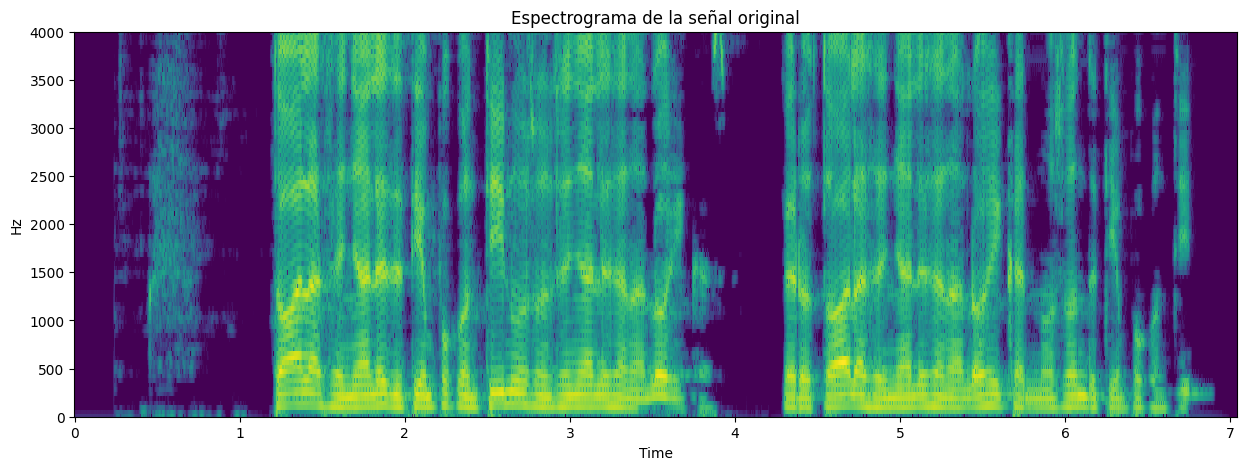

In [4]:
# Load an example audio file using pydub (replace with your audio file path)
audio = AudioSegment.from_file("audio.wav")  # or .wav, etc.
audio_data = audio.get_array_of_samples()
audio_data = audio_data - np.mean(audio_data)
audio_data = audio_data/max(audio_data)
# Convert AudioSegment to numpy array
fs_org = audio.frame_rate # Frecuencia de muestreo
t = np.arange(0,len(audio_data)*1/fs_org, 1/fs_org)
plt.figure(figsize = (15,5))
plot_spectrogram(audio_data, fs_org)
plt.title('Espectrograma de la señal original')
plt.ylim(0,4e3)
display(HTML(f"<h4>Reproduciendo Audio Original"))
display(Audio(data = audio_data, rate = fs_org))


## Filtro pasa-bajas de entrada

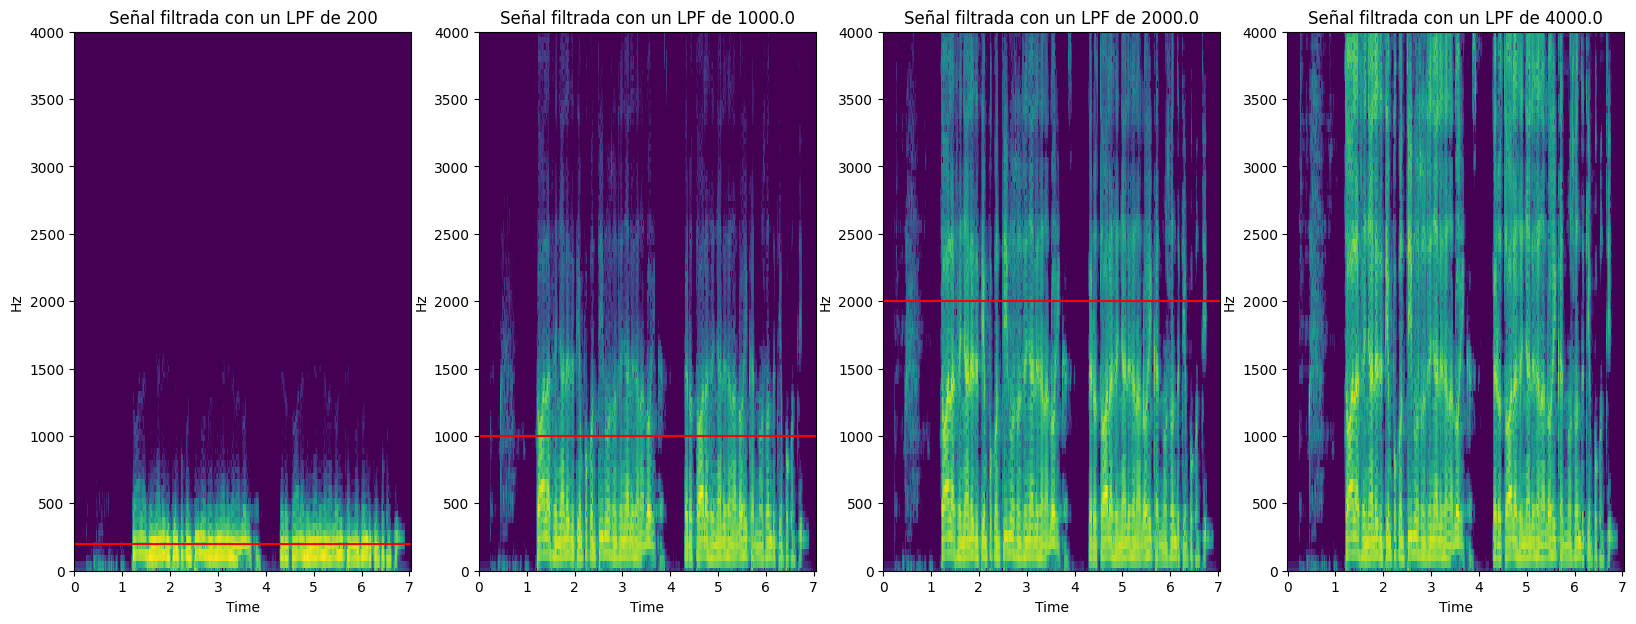

In [5]:
# Parameters for the low-pass filter
cutoff_list = [200, 1e3, 2e3, 4e3]# np.arange(200, 2e3, 300)  # Desired cutoff frequency of the filter, in Hz
order = 4  # Filter order

plt.figure(figsize = (20,7))
for i,cutoff in enumerate(cutoff_list):
  filtered_data = lowpass_filter(audio_data, cutoff, fs_org, order)
  # Apply the filter to the data
  plt.subplot(1,4,i+1)
  plot_spectrogram(filtered_data, fs_org)
  plt.title(f'Señal filtrada con un LPF de {cutoff}')
  plt.ylim(0,4e3)
  plt.hlines(cutoff, xmin = 0, xmax = max(t), colors = 'r')
  display(HTML(f"<h4>Reproduciendo Audio con fmax: {cutoff}</h4>"))
  display(Audio(data = filtered_data, rate = fs_org))



## Muestreo

### Senoidal

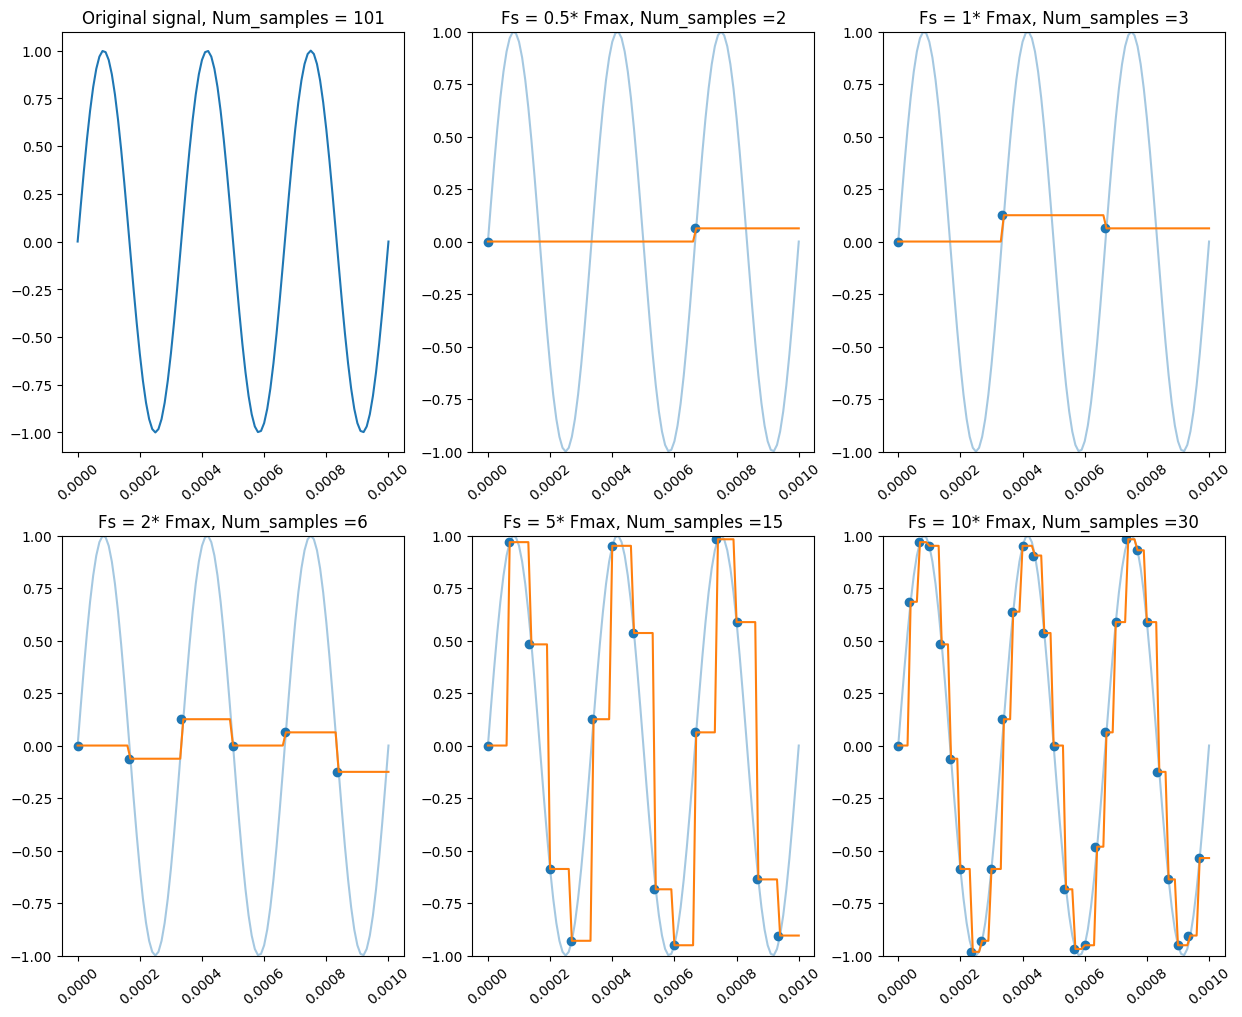

In [6]:
scaling_factor_list = [0.5, 1, 2, 5, 10]
plt.figure(figsize = (15,12))
plt.subplot(2,3,1)
fmax = 3e3
fs = 100e3
t_sin_org = np.arange(0,(3*1/fmax) + 1/fs, 1/fs)
sin_signal_org = np.sin(2*np.pi*fmax*t_sin_org )
plt.title('Original signal, Num_samples = ' + str(len(sin_signal_org)))
plt.plot(t_sin_org, sin_signal_org)
plt.xticks(rotation=40)

for i,scaling_factor in enumerate(scaling_factor_list):
  fs_dest = scaling_factor * fmax

  sin_signal, t_samples, samples = sample_and_hold(t_sin_org, sin_signal_org, fs, fs_dest)
  plt.subplot(2,3,i+2)
  plt.plot(t_sin_org, sin_signal_org, '-', alpha = 0.4)
  plt.plot(t_sin_org, sin_signal)
  plt.scatter(t_samples, samples)
#  tck_s = interpolate.splrep(t_sin_org, sin_signal_org, s=len(t_sin))
#  plt.plot(t_sin, interpolate.BSpline(*tck_s)(t_sin))


  plt.title('Fs = ' +  str(scaling_factor) + '* Fmax,' + ' Num_samples =' + str(len(samples)))

  plt.ylim([-1,1])
  plt.xticks(rotation=40)

### Muestreo en audio

In [7]:
audio = AudioSegment.from_file("audio.wav")  # or .wav, etc.
audio_data = audio.get_array_of_samples()
audio_data = audio_data - np.mean(audio_data)
audio_data = audio_data/max(audio_data)
# Convert AudioSegment to numpy array
fs_org = audio.frame_rate
t = np.arange(0,len(audio_data)*1/fs_org, 1/fs_org)


In [8]:
audio_data_8k = resample(audio_data, int(len(filtered_data)/6))
fs_org = 8e3
t_8k = np.arange(0,len(audio_data_8k)*1/fs_org, 1/fs_org)

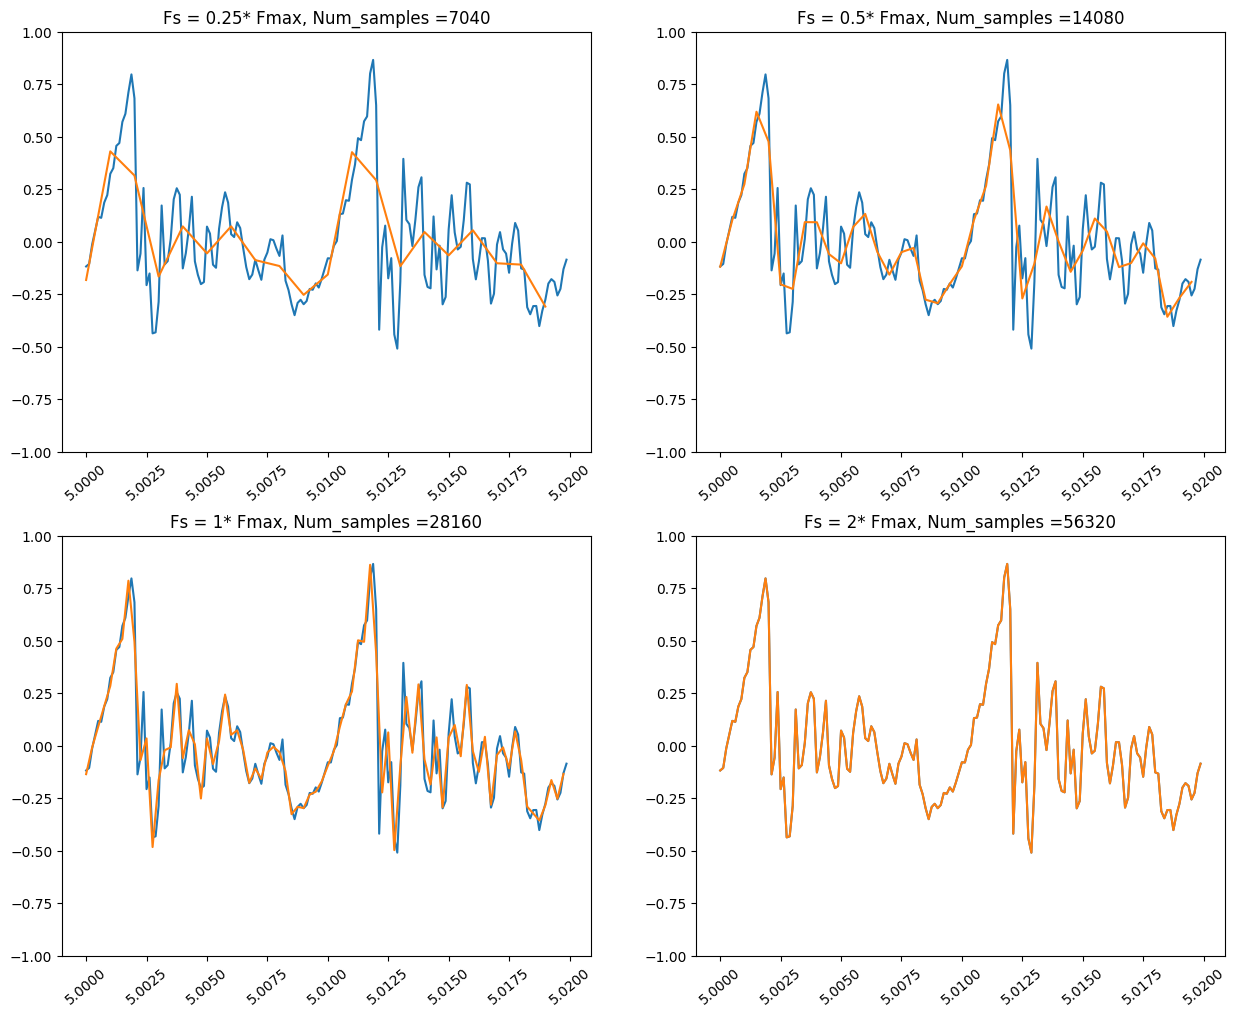

In [9]:
Fmax = 4e3

window_analysis = [5, 5.02] #ini_time, end_time en segundos
interest_samples_org = np.where((t_8k >= window_analysis[0]) & (t_8k <=window_analysis[1]))[0]
scaling_factor_list = [0.25, 0.5, 1, 2]

resampled_signal_list = []
t_new_list = []

plt.figure(figsize = (15,12))
for i,scaling_factor in enumerate(scaling_factor_list):
  fs_new = scaling_factor*Fmax
  resample_factor = fs_new / fs_org
  resampled_signal = resample(audio_data_8k, int(len(audio_data_8k) * resample_factor))
  t_new = np.arange(0,len(resampled_signal)*1/fs_new, 1/fs_new)
  resampled_signal_list.append(resampled_signal)
  t_new_list.append(t_new)

  interest_samples = np.where((t_new >= window_analysis[0]) & (t_new <=window_analysis[1]))[0]
  plt.subplot(2,2,i+1)
  plt.plot(t_8k[interest_samples_org], audio_data_8k[interest_samples_org], label = 'Original')
  plt.plot(t_new[interest_samples], resampled_signal[interest_samples], label = 'sample')
  plt.title('Fs = ' +  str(scaling_factor_list[i]) + '* Fmax,' + ' Num_samples =' + str(len(resampled_signal)))
  plt.ylim([-1,1])
  plt.xticks(rotation=40)
plt.show()



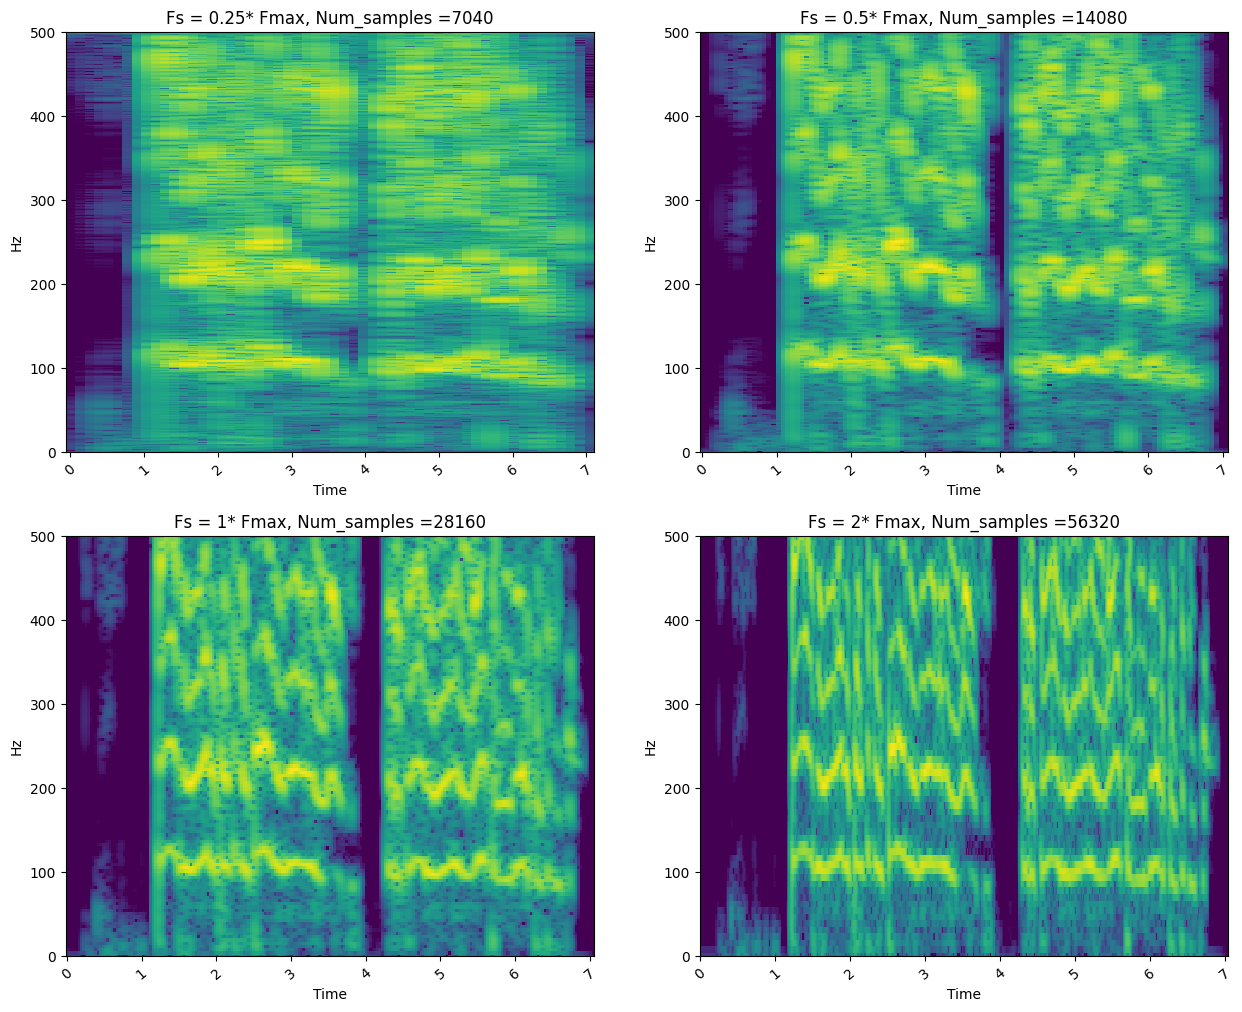

In [10]:
plt.figure(figsize = (15,12))
for i,resampled_signal in enumerate(resampled_signal_list):
  fs_new = scaling_factor_list[i] * Fmax
  t_new = t_new_list[i]
  interest_samples = np.where((t_new >= window_analysis[0]) & (t_new <=window_analysis[1]))[0]
  plt.subplot(2,2,i+1)
  plot_spectrogram(resampled_signal, fs_new)
  plt.title('Fs = ' +  str(scaling_factor_list[i]) + '* Fmax,' + ' Num_samples =' + str(len(resampled_signal)))
  plt.ylim(0, 500)
  plt.xticks(rotation=40)

In [11]:
for scaling_factor in scaling_factor_list:
  fs_new = scaling_factor * Fmax
  display(HTML(f"<h4>Reproduciendo Audio con fs: {fs_new} </h4>"))
  display(Audio(data = audio_data_8k, rate = fs_new))

display(HTML(f"<h4>Reproduciendo Audio con fs: 16k </h4>"))
display(Audio(data = audio_data_8k, rate = 16e3))


## Cuantización

### Bits de cuantización señal senoidal

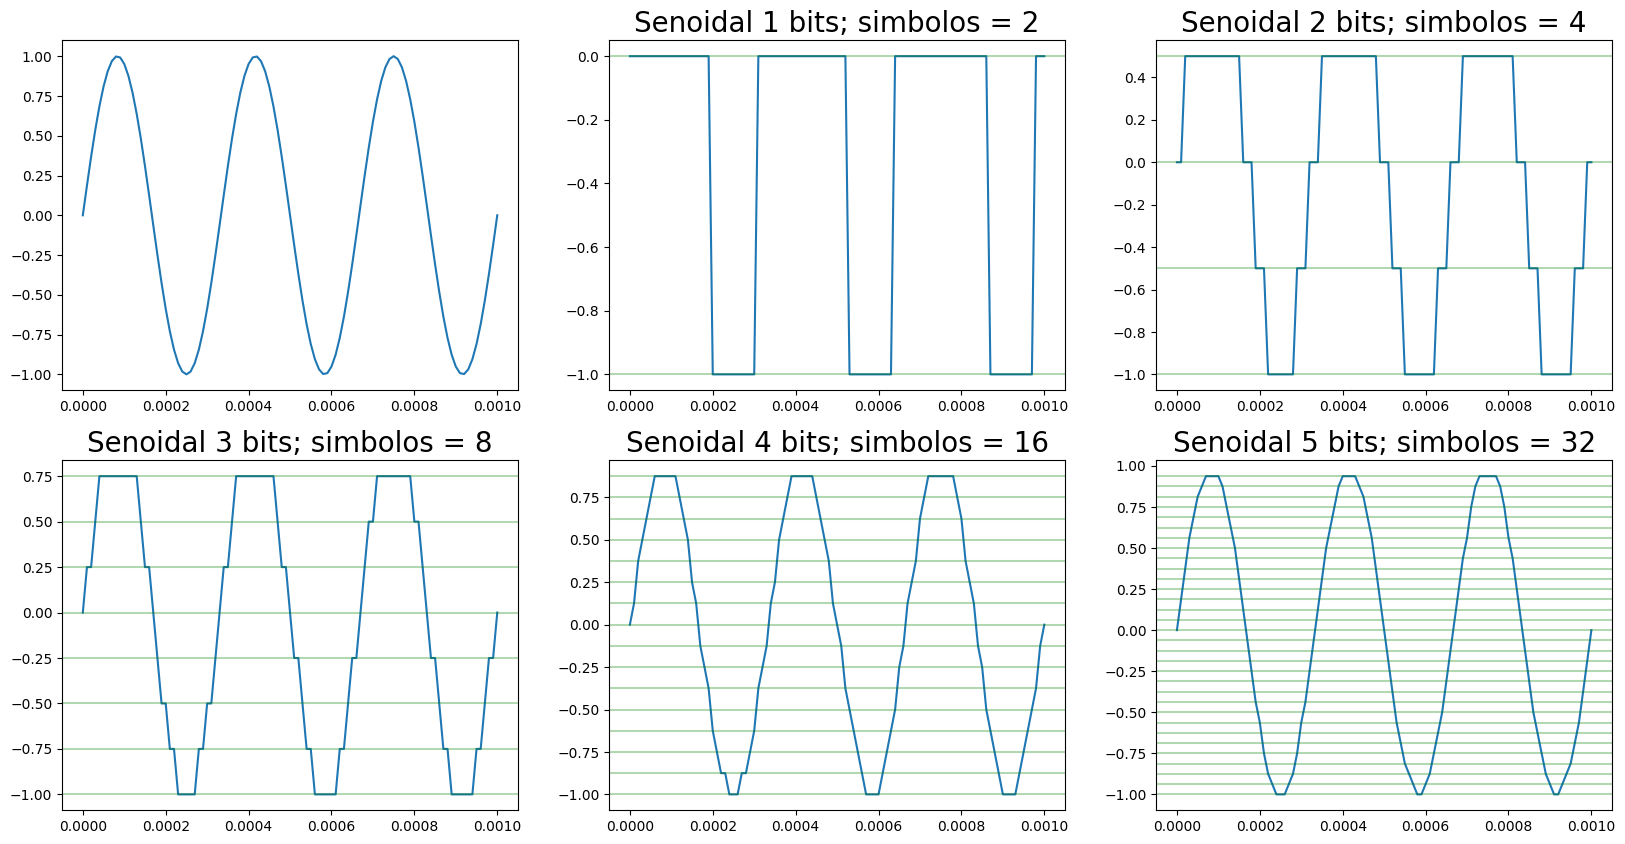

In [12]:
fmax = 3e3
fs = 100e3
t_sin_org = np.arange(0,(3*1/fmax) + 1/fs, 1/fs)
sin_signal_org = np.sin(2*np.pi*fmax*t_sin_org )
plt.figure(figsize=(20,10))
plt.subplot(2, 3, 1)
plt.plot(t_sin_org, sin_signal_org)
for i,bit in enumerate(range(1, 6)):
  x_bits=fxquant(sin_signal_org,bit)
  plt.subplot(2, 3, i+2)
  plt.plot(t_sin_org, x_bits)
  plt.title('Senoidal ' +str(bit) + ' bits' + '; simbolos = ' + str(int(2**bit)),fontsize=20)
  for simbols in set(x_bits):
    plt.axhline(y=simbols, color = 'g', alpha = 0.3)





### SNR de cuantización

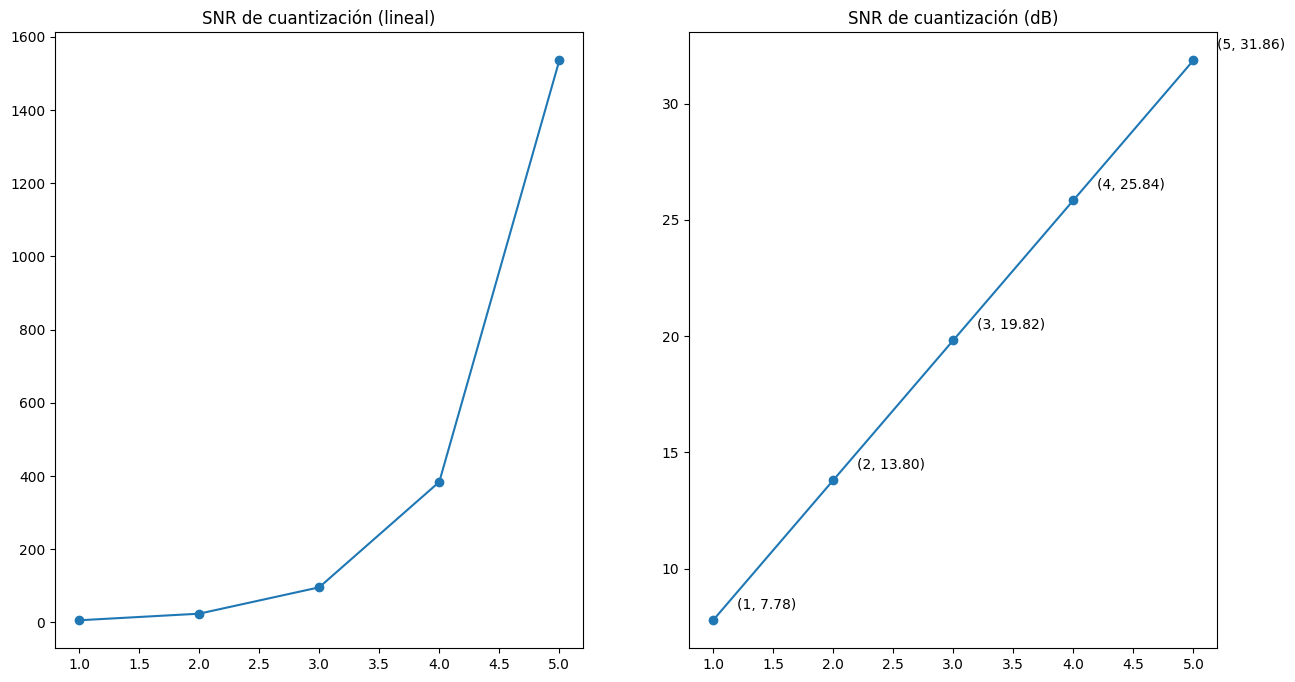

In [13]:
bits_array = np.arange(1,6,1)
SNR_array = np.asarray([2**(2* bit) for bit in bits_array]) * 3/2
SNR_array_dB = [10 * np.log10(snr_lineal) for snr_lineal in SNR_array]

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(bits_array, SNR_array, 'o-')
plt.title('SNR de cuantización (lineal)')
plt.subplot(1, 2, 2)
plt.plot(bits_array, SNR_array_dB, 'o-')
plt.title('SNR de cuantización (dB)')
for i, j in zip(bits_array, SNR_array_dB):
   plt.text(i+0.2, j+0.5, '({}, {:.2f})'.format(i, j))


### Bits de cuantización en audio

In [14]:
audio = AudioSegment.from_file("audio.wav")  # or .wav, etc.
audio_data = audio.get_array_of_samples()
audio_data = audio_data - np.mean(audio_data)
audio_data = audio_data/max(audio_data)
# Convert AudioSegment to numpy array
fs_org = audio.frame_rate
t = np.arange(0,len(audio_data)*1/fs_org, 1/fs_org)
#LPF
audio_data_8k = resample(audio_data, int(len(filtered_data)/6))
fs_org = 8e3
t_8k = np.arange(0,len(audio_data_8k)*1/fs_org, 1/fs_org)
#Muestreo
Fmax = 4e3
fs_new = 2*Fmax
resample_factor = fs_new / fs_org
resampled_audio_data = resample(audio_data_8k, int(len(audio_data_8k) * resample_factor))
t_sampled = np.arange(0,len(resampled_audio_data)*1/fs_new, 1/fs_new)
display(HTML(f"<h4>Audio antes de la cuantización</h4>"))
display(Audio(data = resampled_audio_data, rate = fs_new))

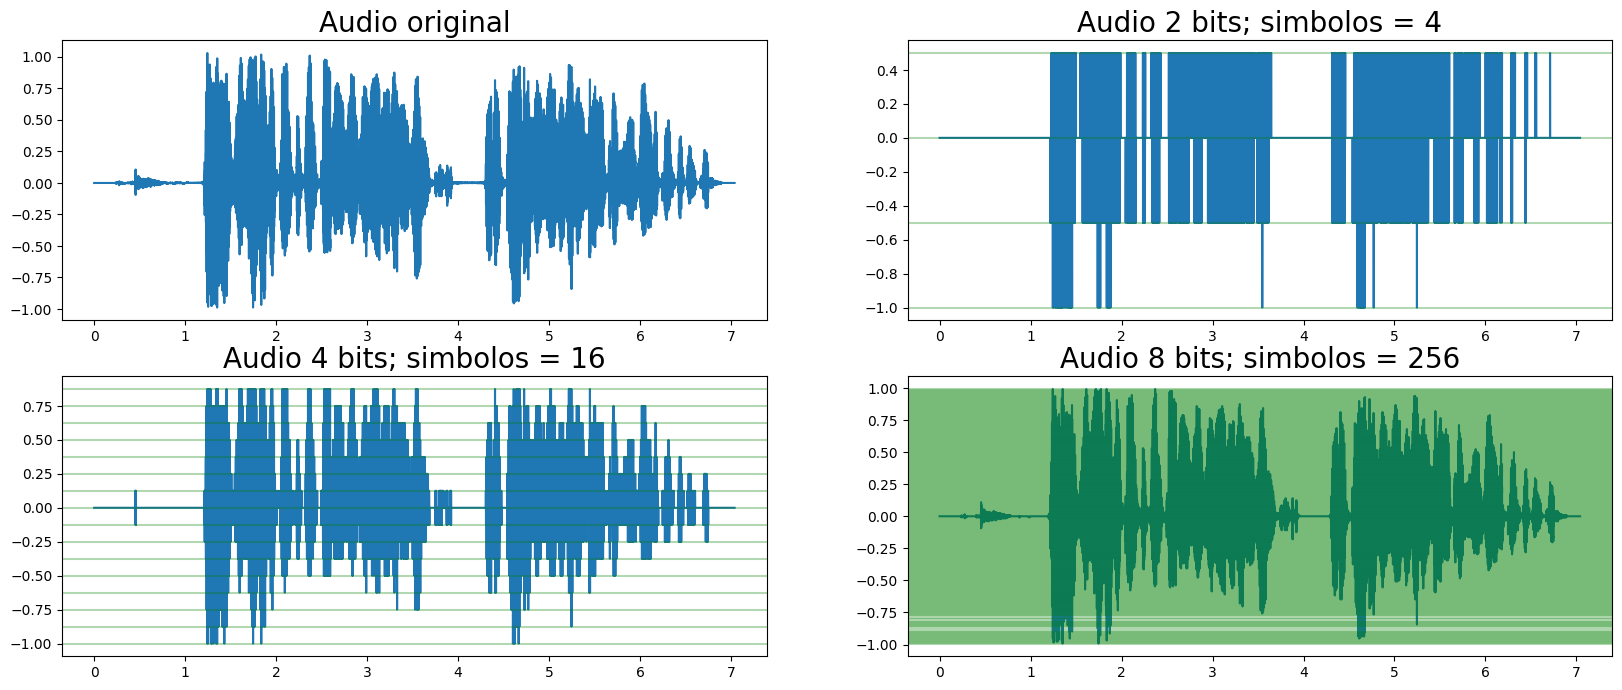

In [15]:
bits = [2, 4, 8]
plt.figure(figsize=(20,8))
plt.subplot(2, 2, 1)
plt.plot(t_sampled, resampled_audio_data)
plt.title('Audio original',fontsize=20)

for i,bit in enumerate(bits):
  x_bits=fxquant(resampled_audio_data,bit)
  plt.subplot(2, 2, i+2)
  plt.plot(t_sampled, x_bits)
  plt.title('Audio ' +str(bit) + ' bits' + '; simbolos = ' + str(int(2**bit)),fontsize=20)
  for simbols in set(x_bits):
    plt.axhline(y=simbols, color = 'g', alpha = 0.3)
  display(HTML(f"<h4>Audio {bit} bits</h4>"))
  display(Audio(data = x_bits, rate = fs_new))





